In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import warnings
import seaborn as sns
import matplotlib
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
from scipy import stats, linalg
from yellowbrick.regressor import CooksDistance
from yellowbrick.datasets import load_concrete
from statsmodels.stats.outliers_influence import variance_inflation_factor as statsmodel_VIF

# Intro

The aim of this work is to look for evidence of race-based interest rate discrimination in mortgage loans, based on publicly released lending data compiled as part of the Home Mortgage Disclosure Act.  The dataset contains per-loan data, tracking numerous descriptors of the loan's financial details as well as the applicant's demographic and financial information. 

Our analyis shows that in 2019, in the DC metropolitan area, African American's are subject to an increase of 12 basis points in interest rates (compared to the reference race - White), even after various factors that underwriters use to determine interest rates are taken into account.  We show that this "discriminatory" effect is more strongly expressed in higher interest rate loans, and amongst older applicants. We also observe that Asian Americans face mild but consistent reverse discrimination in the DC area, receiving 3 basis points lower interest rates on average.  The technical approach is to fit a linear regression model predicting interest rates, controlling for numerous covariates, including race, and interpreting the strength of the regression coefficient.  We then extend our analysis to other states in the DMV region - Delaware and Virginia.  The following are the main sections of the notebook:

<strong>0 - Preprocessing and Definitions</strong> <br/>
<strong>1 - Analysis on DC region</strong> <br/>
<strong>2 - Analysis over DMV states - DC, Maryland, Virginia</strong> <br/>
<strong>3 - Conclusions</strong> <br/>
<strong>4 - Supplementary</strong> <br/>
<strong>5 - References</strong> <br/>

All data is publicly available via the Home Mortgage Disclosure Act at:
https://ffiec.cfpb.gov/data-browser/
<br/>
Schema for reading tables can be found here: https://github.com/cfpb/hmda-platform/blob/master/docs/v2/spec/Modified%20LAR%20Schema.csv

Edwin Yuan, 2021

# 0 - Pre-Processing and Definitions

In [2]:
# define various pre-processing functions here

def age_convert(a):
    isnan = False

    if type(a) is float:
        isnan = np.isnan(a)
    if isnan or a == '8888':
        return np.nan
    elif a == '9999':
        return 0
    elif a == '>74':
        return 74
    elif a == '<25':
        return 25
    else:
        nums = []
        for str_chnk in a.split('-'):
            digit_list = [c for c in str_chnk if c.isdigit()]
            nums.append(int("".join(digit_list)))

        return(np.mean(nums))

def d2i_convert(a):
    isnan = False

    if type(a) is float:
        isnan = np.isnan(a)
    if a =='nan' or a == 'Exempt' or isnan:
        return np.nan
    else:
        nums = []
        for str_chnk in a.split('-'):
            digit_list = [c for c in str_chnk if c.isdigit()]
            nums.append(int("".join(digit_list)))

        return(np.mean(nums))

def race_convert(a, mode='string'):
    if a == 1:
        return 'American_Indian_or_Alaska_Native' if mode == 'string' else np.nan
    elif (a == 2) or (a == 21) or (a == 22) or (a == 23) or (a == 24)  or (a == 25) or (a == 26) or (a == 27):
        return 'Asian' if mode == 'string' else 2
    elif a == 3:
        return 'Black' if mode == 'string' else 1
    elif (a == 4) or (a == 41) or (a == 42) or (a == 42) or (a == 43) or (a == 44):
        return 'Native_Hawaiian_or_Other_Pacific_Islander' if mode == 'string' else 4
    elif a == 5:
        return 'White' if mode == 'string' else 0
    elif (a == 6) or (a == 7) or (a == 8):
        return 'None' if mode == 'string' else np.nan
    else:
        return 'None' if mode == 'string' else np.nan



In [3]:
class MortgageAnalyzer:
    def __init__(self):
        self.df = None
        self.df_filt = None
        self.analyis_keys = None
        self.outlier_removal_counter = None
        
    def load_dataset(self, filename):
        self.df = pd.read_csv(filename)
        
        # forces values to be floats
        self.df['interest_rate'] = pd.to_numeric(self.df['interest_rate'], errors='coerce');
        self.df['property_value'] = pd.to_numeric(self.df['property_value'], errors='coerce');
        self.df['loan_to_value_ratio'] = pd.to_numeric(self.df['loan_to_value_ratio'], errors='coerce');
        self.df['loan_term'] = pd.to_numeric(self.df['loan_term'], errors='coerce');
        
        # apply preprocessing functions
        self.df['debt_to_income'] = self.df['debt_to_income_ratio'].apply(d2i_convert)
        self.df['age'] = self.df['applicant_age'].apply(age_convert)
        self.df['co-age'] = self.df['co-applicant_age'].apply(age_convert)
        self.df['race'] = self.df['applicant_race-1'].apply(race_convert)
        self.df['numeric_race'] = self.df['applicant_race-1'].apply(race_convert, args=('numeric',))
        self.df['co-race'] = self.df['co-applicant_race-1'].apply(race_convert)
        self.df['merge_age'] = self.df[["age", "co-age"]].max(axis=1)
        self.df['merge_race_age'] = self.df['race'].astype(str) + '_'  + \
                pd.cut(self.df['merge_age'], bins=[0,30,49,200], labels=['less_than_30','30_to_49','greater_than_50']).astype(str)
        
        # set outlier removal counter to 0
        self.outlier_removal_counter = 0
    
    def filter_df(self):
        self.df_filt = self.df[(self.df['derived_race'] != 'Joint') & (self.df['derived_race'] != 'Free Form Text Only')]
        self.df_filt = self.df_filt[~np.isnan(self.df_filt['loan_amount']) & ~np.isnan(self.df_filt['interest_rate']) \
                    & ~np.isnan(self.df_filt['property_value']) & ~np.isnan(self.df_filt['income'])]
        self.df_filt = self.df_filt[self.df_filt['loan_purpose'] == 1] # isolate property loans
        self.df_filt = self.df_filt[~np.isnan(self.df_filt['loan_term'])]
        self.df_filt = self.df_filt[~np.isnan(self.df_filt['debt_to_income'])]
        self.df_filt = self.df_filt[~np.isnan(self.df_filt['merge_age'])]
        self.df_filt = self.df_filt[(self.df_filt['race'] != 'None') | (self.df_filt['co-race'] != 'None')]

        # keep only races - White, Black or Asian
        self.df_filt = self.df_filt[(self.df_filt['race']=='White') | (self.df_filt['race']=='Black') | (self.df_filt['race']=='Asian')]

        # clean up data/ remove outliers
        self.df_filt = self.df_filt[(self.df_filt['income']< self.df_filt['income'].quantile(0.99)) & (self.df_filt['income']> self.df_filt['income'].quantile(0.01))]
        #self.df_filt = self.df_filt[(self.df_filt['interest_rate']> self.df_filt['interest_rate'].quantile(0.01))]
        self.df_filt = self.df_filt[(self.df_filt['loan_to_value_ratio']< self.df_filt['loan_to_value_ratio'].quantile(0.99))]
        self.df_filt = self.df_filt[self.df_filt['loan_to_value_ratio'] <= 100]
            
    def convert_categoricals(self):
        self.df_cat = self.df_filt.copy()
        
        # create dummy columns for all categorical dependent variables
        self.df_cat = pd.get_dummies(self.df_cat,columns=['derived_race'], drop_first=False)
        self.df_cat = pd.get_dummies(self.df_cat,columns=['preapproval'], drop_first=False)
        self.df_cat = pd.get_dummies(self.df_cat,columns=['business_or_commercial_purpose'], drop_first=False)
        self.df_cat = pd.get_dummies(self.df_cat,columns=['reverse_mortgage'], drop_first=False)
        self.df_cat = pd.get_dummies(self.df_cat,columns=['purchaser_type'], drop_first=False)
        self.df_cat = pd.get_dummies(self.df_cat,columns=['race'], drop_first=False)
        self.df_cat = pd.get_dummies(self.df_cat,columns=['co-race'], drop_first=False)
        self.df_cat = pd.get_dummies(self.df_cat,columns=['open-end_line_of_credit'], drop_first=False)
        self.df_cat = pd.get_dummies(self.df_cat,columns=['initially_payable_to_institution'], drop_first=False)
        self.df_cat = pd.get_dummies(self.df_cat,columns=['occupancy_type'], drop_first=False)
        self.df_cat = pd.get_dummies(self.df_cat,columns=['balloon_payment'], drop_first=False)
        self.df_cat = pd.get_dummies(self.df_cat,columns=['applicant_credit_score_type'], drop_first=False)
        self.df_cat = pd.get_dummies(self.df_cat,columns=['merge_race_age'], drop_first=False)

        #  fuse the two race columns
        for col_name in list(self.df_cat.columns):
            if col_name[:5]== 'race_':
                try:
                    self.df_cat[col_name] = self.df_cat[col_name] + self.df_cat['co-'+col_name]
                    self.df_cat[col_name].where(self.df_cat[col_name]<=1, 1, inplace=True)
                except:
                    pass
                del self.df_cat['co-'+col_name]

        # replace all spaces in column names with underscore
        self.df_cat.columns = self.df_cat.columns.str.replace(' ','_')
        self.df_cat.columns = self.df_cat.columns.str.replace('-','_')

        # delete unneeded dummy columns
        del self.df_cat['preapproval_2']
        del self.df_cat['business_or_commercial_purpose_2']
        del self.df_cat['reverse_mortgage_2'] # there are no reverse mortgages in this dataset
        del self.df_cat['purchaser_type_0']
        del self.df_cat['race_White'] 
        del self.df_cat['merge_race_age_White_30_to_49']
        del self.df_cat['initially_payable_to_institution_3'] 
        del self.df_cat['occupancy_type_1'] 
        del self.df_cat['balloon_payment_2'] 
        del self.df_cat['applicant_credit_score_type_9'] 
        
    def reduce_keys(self, analysis_keys):
        self.analysis_keys = analysis_keys
        self.df_cat = self.df_cat[analysis_keys]
         
    def reduce_rows(self, df_inds_to_keep):
        self.df_cat = self.df_cat.iloc[df_inds_to_keep]
        
        self.outlier_removal_counter += 1
        print(f'Outliers have been removed {self.outlier_removal_counter} times.')
    
    def delete_all(self):
        self.df = None
        self.df_filt = None
        self.analyis_keys = None
        self.outlier_removal_counter = None

        

# 1 - Analysis on DC region

In [4]:
MA = MortgageAnalyzer()
MA.load_dataset("state_DC_2019.csv")
MA.filter_df()
MA.convert_categoricals()
display(MA.df_filt)

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,tract_one_to_four_family_homes,tract_median_age_of_housing_units,debt_to_income,age,co-age,race,numeric_race,co-race,merge_age,merge_race_age
10,2019,5493003GQDUH26DNNH17,47894,DC,11001.0,1.100101e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,734,56,42.0,39.5,0.0,White,0.0,None,39.5,White_30_to_49
11,2019,5493003GQDUH26DNNH17,47894,DC,11001.0,1.100101e+10,C,VA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,585,59,55.0,29.5,0.0,Black,1.0,None,29.5,Black_less_than_30
13,2019,5493003GQDUH26DNNH17,47894,DC,11001.0,1.100100e+10,C,VA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,1132,76,33.0,49.5,0.0,White,0.0,None,49.5,White_greater_than_50
15,2019,5493003GQDUH26DNNH17,47894,DC,11001.0,1.100100e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,980,76,40.0,39.5,0.0,Asian,2.0,None,39.5,Asian_30_to_49
16,2019,5493003GQDUH26DNNH17,47894,DC,11001.0,1.100100e+10,C,VA:First Lien,Single Family (1-4 Units):Site-Built,Joint,...,1060,72,33.0,29.5,29.5,White,0.0,None,29.5,White_less_than_30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37281,2019,213800QUAI2VH5YM6310,47894,DC,11001.0,1.100100e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,317,65,25.0,59.5,59.5,White,0.0,White,59.5,White_greater_than_50
37290,2019,213800QUAI2VH5YM6310,47894,DC,11001.0,1.100101e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,938,76,33.0,29.5,0.0,White,0.0,None,29.5,White_less_than_30
37303,2019,213800QUAI2VH5YM6310,47894,DC,11001.0,1.100101e+10,C,VA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,627,52,25.0,29.5,0.0,Black,1.0,None,29.5,Black_less_than_30
37319,2019,549300MXJA09WZJ0DV55,47894,DC,11001.0,1.100101e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,100,49,45.0,29.5,0.0,Black,1.0,None,29.5,Black_less_than_30


In [5]:
MA.df_filt.describe()

,activity_year,derived_msa-md,county_code,census_tract,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,...,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units,debt_to_income,age,co-age,numeric_race,merge_age
count,6089.0,6089.000000,6070.0,6.070000e+03,6089.000000,6089.000000,6089.000000,6089.000000,6089.0,6089.000000,...,6089.000000,6089.000000,6089.000000,6089.000000,6089.000000,6089.000000,6088.000000,6089.000000,6089.000000,6089.000000
mean,2019.0,47744.552472,11001.0,1.100101e+10,1.039744,11.905896,1.933487,1.124158,1.0,1.030054,...,114342.092298,112.408113,820.693710,915.694860,62.779931,34.565117,38.463863,15.228363,0.344720,39.483248
std,0.0,2671.418609,0.0,3.226431e+03,0.394272,23.281913,0.249198,0.443995,0.0,0.170750,...,6397.705652,62.203685,424.495534,471.968907,18.151135,8.924531,10.844401,20.743400,0.631706,11.421541
min,2019.0,0.000000,11001.0,1.100100e+10,1.000000,0.000000,1.000000,1.000000,1.0,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,25.000000,0.000000,0.000000,25.000000
25%,2019.0,47894.000000,11001.0,1.100100e+10,1.000000,0.000000,2.000000,1.000000,1.0,1.000000,...,114700.000000,60.000000,520.000000,575.000000,56.000000,25.000000,29.500000,0.000000,0.000000,29.500000
50%,2019.0,47894.000000,11001.0,1.100101e+10,1.000000,3.000000,2.000000,1.000000,1.0,1.000000,...,114700.000000,107.000000,737.000000,891.000000,70.000000,33.000000,39.500000,0.000000,0.000000,39.500000
75%,2019.0,47894.000000,11001.0,1.100101e+10,1.000000,6.000000,2.000000,1.000000,1.0,1.000000,...,114700.000000,171.000000,1053.000000,1270.000000,76.000000,41.000000,39.500000,29.500000,1.000000,39.500000
max,2019.0,47894.000000,11001.0,1.100101e+10,8.000000,72.000000,2.000000,3.000000,1.0,2.000000,...,114700.000000,236.000000,2141.000000,2486.000000,76.000000,60.000000,74.000000,74.000000,2.000000,74.000000


# 1.1 - Some Visualizations

numeric_race: 0 - White, 1 - Black, 2 - Asian
N - White: 4517, Black: 1045, Asian: 527
Other races excluded due to lack of data


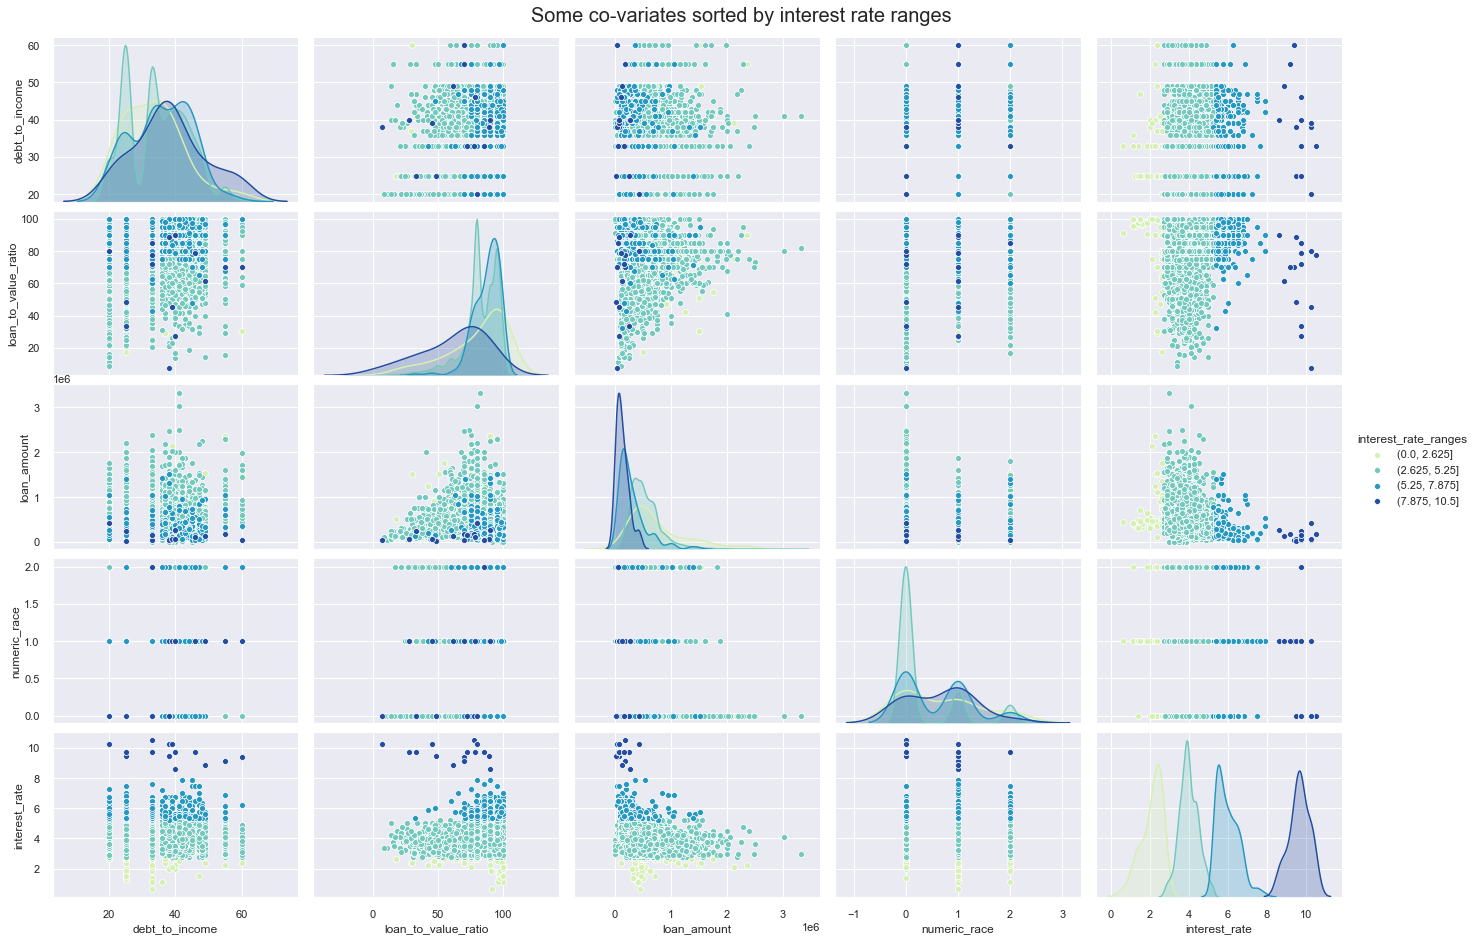

In [6]:
vis_keys = ['debt_to_income', 'loan_to_value_ratio', 'loan_amount', 'numeric_race', 'interest_rate_ranges', 'interest_rate'] 

ir_min = MA.df_filt['interest_rate'].min()#.quantile(0.01)
ir_max = MA.df_filt['interest_rate'].max()#.quantile(0.99)
bins = np.linspace(ir_min, ir_max, 5)  # Divide between a_min and vcc_max into 10
MA.df_filt['interest_rate_ranges'] = pd.cut(MA.df_filt['interest_rate'], bins=bins)


sns.set_style('white')
sns.set()
g = sns.pairplot(MA.df_filt[vis_keys], hue='interest_rate_ranges', hue_order=MA.df_filt['interest_rate_ranges'].cat.categories, palette='YlGnBu', aspect=1.5)
g.fig.suptitle('Some co-variates sorted by interest rate ranges', y=1.03, size= 20)

counter = lambda x: len(MA.df_filt[MA.df_filt['race']==x])
N_white = counter('White'); N_black = counter('Black');  N_asian = counter('Asian');
print('numeric_race: 0 - White, 1 - Black, 2 - Asian')
print(f'N - White: {N_white}, Black: {N_black}, Asian: {N_asian}')
print('Other races excluded due to lack of data')

- loan to value appears positively correlated to interest rate as expected, except for the highest interest rate group
- the higher interest rates appear to be restricted to smaller loan amounts, < 700,000 usd, but peaked at around 100,000 usd
- the highest interest rate group includes White and Black but very few Asians (would have to be normalized by # of people for better comparison)

# 1.2 - Isolate specific keys for regression analysis

In [7]:
analysis_keys = ['loan_amount','interest_rate', 'loan_to_value_ratio', 'property_value', 'income', 'loan_term', 'debt_to_income', 'merge_age', 'preapproval_1', 'business_or_commercial_purpose_1',
        'purchaser_type_1', 'purchaser_type_2', 'purchaser_type_3', 'purchaser_type_5', 'purchaser_type_6', 'purchaser_type_8', 'purchaser_type_9', 'purchaser_type_71', 'purchaser_type_72',
        'open_end_line_of_credit_1', 'race_Asian', 'race_Black'] 
    
MA.reduce_keys(analysis_keys)
display(MA.df_cat)

,loan_amount,interest_rate,loan_to_value_ratio,property_value,income,loan_term,debt_to_income,merge_age,preapproval_1,business_or_commercial_purpose_1,...,purchaser_type_3,purchaser_type_5,purchaser_type_6,purchaser_type_8,purchaser_type_9,purchaser_type_71,purchaser_type_72,open_end_line_of_credit_1,race_Asian,race_Black
10,465000.0,4.750,94.69,485000.0,112.0,360.0,42.0,39.5,0,0,...,0,0,0,0,0,0,0,0,0,0
11,415000.0,4.375,100.00,425000.0,83.0,360.0,55.0,29.5,1,0,...,0,0,0,0,0,0,0,0,0,1
13,625000.0,4.375,100.00,625000.0,179.0,360.0,33.0,49.5,1,0,...,0,0,0,0,0,0,0,0,0,0
15,445000.0,3.750,100.00,735000.0,122.0,296.0,40.0,39.5,0,0,...,0,0,0,0,0,0,0,0,1,0
16,555000.0,4.375,98.49,575000.0,165.0,360.0,33.0,29.5,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37281,215000.0,3.875,75.00,285000.0,181.0,360.0,25.0,59.5,0,0,...,1,0,0,0,0,0,0,0,0,0
37290,355000.0,3.990,97.00,365000.0,103.0,360.0,33.0,29.5,0,0,...,0,0,0,0,0,1,0,0,0,0
37303,345000.0,3.250,100.00,355000.0,100.0,360.0,25.0,29.5,0,0,...,0,0,0,0,0,0,0,0,0,1
37319,465000.0,3.875,95.00,495000.0,79.0,360.0,45.0,29.5,0,0,...,0,0,0,0,0,0,0,0,0,1


# 1.3 - Define Statistical Analysis Code

In [8]:
class StatAnalysis:
    def variance_inflation_factor(self, df, analysis_keys):
        # convert dataframe to array
        df_ary = df.to_numpy()
        
        print('VIF for array of shape: ', df_ary.shape, '\n')
        
        # add intercept to model
        df_ary_const = np.hstack((df_ary,np.ones((df_ary.shape[0],1))))
        
        # compute VIF
        for i in range(df_ary_const.shape[1]-1):
            print(f'{analysis_keys[i]}: {statsmodel_VIF(df_ary_const, i)}')
            
    def partial_corr(self, df, analysis_keys, plot=False, verbose = False):   
        # convert to array and add intercept to model
        df_ary = df.to_numpy()
        C = np.hstack((df_ary,np.ones((df_ary.shape[0],1))))
        
        p = C.shape[1]
        P_corr = np.zeros((p, p), dtype=np.float) # P_corr are the partial correlations
        R_corr = np.zeros((p, p), dtype=np.float) # R_corr are the regular correlations

        res_list = []
        for i in range(p):
            P_corr[i, i] = 1
            for j in range(i+1, p):
                idx = np.ones(p, dtype=np.bool)
                idx[i] = False
                idx[j] = False
                beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
                beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

                res_j = C[:, j] - C[:, idx].dot( beta_i)
                res_i = C[:, i] - C[:, idx].dot(beta_j)
                R2_j = 1 - np.sum(res_j**2)/np.sum((C[:,j] - np.mean(C[:,j]))**2)
                R2_i = 1 - np.sum(res_i**2)/np.sum((C[:,i] - np.mean(C[:,i]))**2)
                if verbose:
                    print(f'({i},{j}) - R2_j: {R2_j}, R2_i: {R2_i}')
                res_list.append([(i,j),res_i,res_j])

                # partial correlation
                corr = stats.pearsonr(res_i, res_j)[0]
                P_corr[i, j] = corr
                P_corr[j, i] = corr

                # regular correlation
                corr = stats.pearsonr(C[:, j], C[:, i])[0]
                R_corr[i, j] = corr
                R_corr[j, i] = corr

        if plot:
            # plotting keys
            plt_keys = analysis_keys.copy()

            fig, ax = plt.subplots(figsize=(15,15))
            cax = ax.matshow(P_corr[:-1,:-1], cmap='RdBu_r', vmin=-1, vmax=1)
            plt.yticks(np.arange(P_corr.shape[1]-1), plt_keys, rotation=30)
            plt.xticks(np.arange(P_corr.shape[1]-1), plt_keys, rotation=90)
            plt.title('Regressor Partial Correlation Coefficients', size= 20)
            fig.colorbar(cax)
            

            for i in range(P_corr.shape[0]-1):
                for j in range(P_corr.shape[1]-1):
                    c = round(P_corr[j,i],2)
                    ax.text(i, j, str(c), va='center', ha='center', size=12)
         
        # P_corr are the partial correlations, R_corr are the regular correlations, res_list is a list of residuals
        return P_corr, R_corr, res_list

    def cooks_distance(self, df, analysis_keys, plot=True):   
        analysis_keys_ = analysis_keys.copy()
        analysis_keys_.remove('interest_rate')
        
        # convert to array and add intercept to model
        df_ary = df[analysis_keys_].to_numpy()
        df_ary_const = np.hstack((df_ary,np.ones((df_ary.shape[0],1))))

        # Instantiate and fit the visualizer
        fig = plt.figure()
        visualizer = CooksDistance(ax=plt.gca())
        visualizer.fit(df_ary_const, df['interest_rate'])
        plt.ylabel('Cook\'s Distance')
        plt.xlabel('Datapoints')
        plt.title('Outlier detection by Cook\'s distance')
        if not plot:
            plt.close()

        # specify row indices to keep
        to_keep = np.where(visualizer.distance_ < visualizer.influence_threshold_)[0]

        print(f'{len(to_keep)} datapoints remaining')
        print(f'{visualizer.outlier_percentage_}% of data removed as outliers')
        
        return to_keep
    
    def linear_regression(self, df, analysis_keys, return_keys='', plot=True): 
        analysis_keys_ = analysis_keys.copy()
        analysis_keys_.remove('interest_rate')

        # Using a Pandas DataFrame `df`:
        lm = pg.linear_regression(df[analysis_keys_], df['interest_rate'])
        lm['coef'] = round(lm['coef'],4)
        if plot:
            display(lm)
            
        return_dict = {}
        for r in return_keys:
            return_dict[r] = lm[lm['names'] == r]
            
        # get residuals
        residuals = lm.residuals_
        
        # get predicted y values
        lm = pg.linear_regression(df[analysis_keys_], df['interest_rate'], as_dataframe=False)
        pred = lm['pred']
            
        return return_dict, residuals, pred
    
    def quantile_regression(self, quantile, df, analysis_keys, return_keys, plot=True): 
        independent_keys = analysis_keys.copy()
        independent_keys.remove('interest_rate')
        formula = "interest_rate ~ " + " + ".join(independent_keys)

        #fit the model
        model = smf.quantreg(formula, df).fit(q=quantile)

        if plot:
            print(model.summary())
            
        return_dict = {}
        for r in return_keys:
            # save coefficient, and 95% error bar
            return_dict[r] = [model.params[r], model.conf_int().loc['race_Asian'].diff()[1]/2]
            
        return return_dict
        
        
SA = StatAnalysis()

# 1.4 - Look for Multicollinearity

VIF for array of shape:  (6089, 22) 

loan_amount: 8.72993035441847
interest_rate: 1.358864126149261
loan_to_value_ratio: 2.1010627722849944
property_value: 9.71342482541397
income: 2.3902830424103465
loan_term: 1.143849845153282
debt_to_income: 1.3225049110620015
merge_age: 1.272777054727553
preapproval_1: 1.0322804101156666
business_or_commercial_purpose_1: 1.0722976157272328
purchaser_type_1: 1.3876348442364106
purchaser_type_2: 1.1253631219547364
purchaser_type_3: 1.38758867410957
purchaser_type_5: 1.0369167647123385
purchaser_type_6: 1.6279554507660146
purchaser_type_8: 1.0470529142286773
purchaser_type_9: 1.0456539762185106
purchaser_type_71: 1.3798941177004287
purchaser_type_72: 1.0107046046178303
open_end_line_of_credit_1: 1.891621669465967
race_Asian: 1.0381096911239098
race_Black: 1.1911814202416993


C:\Users\d-edwin.yuan\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\d-edwin.yuan\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


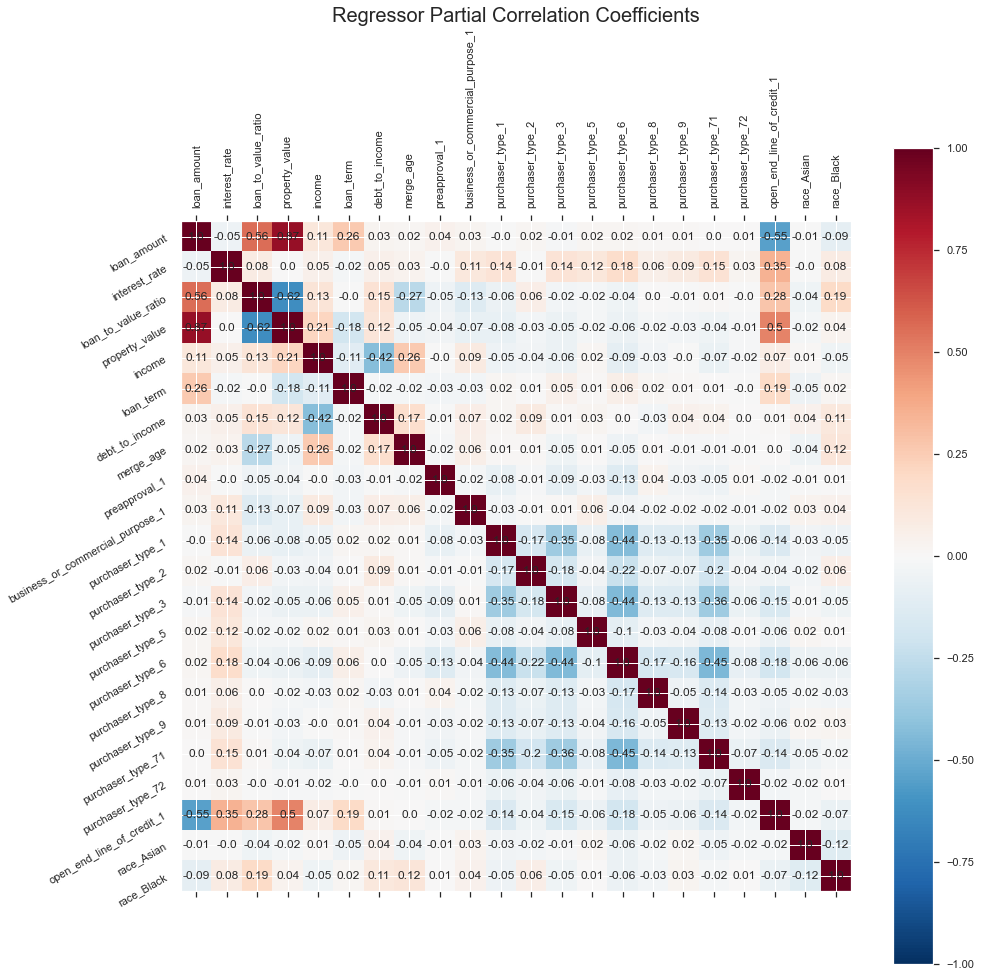

In [9]:
SA.variance_inflation_factor(MA.df_cat, MA.analysis_keys)
_, _, _ = SA.partial_corr(MA.df_cat, MA.analysis_keys, plot=True)


- the VIF for most co-variates is much less than 10, indicating mostly uncorrelated variables
- the highest partial correlation is observed between loan amount and property value (0.87), which makes sense

# 1.5 - Remove outliers using Cook's Distance

5755 datapoints remaining
5.485301363113812% of data removed as outliers
Outliers have been removed 1 times.


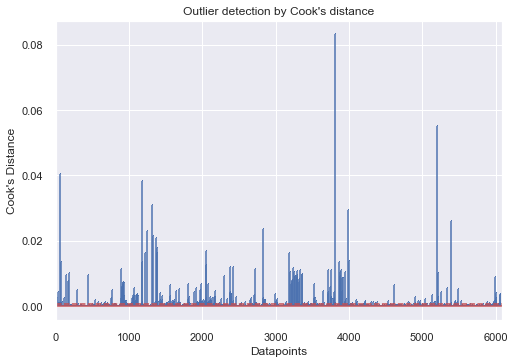

In [10]:
df_ind_to_keep = SA.cooks_distance(MA.df_cat, MA.analysis_keys)
MA.reduce_rows(df_ind_to_keep)

# 1.6 - Linear Regression

In [11]:
return_dict, residuals, lm_pred = SA.linear_regression(MA.df_cat, MA.analysis_keys, ['race_Black', 'race_Asian'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,2.8899,1.012368e-01,28.545715,1.066757e-167,0.36771,0.365394,2.691414e+00,3.088339e+00
1,loan_amount,-0.0000,8.437806e-08,-2.889762,3.869802e-03,0.36771,0.365394,-4.092454e-07,-7.841961e-08
2,loan_to_value_ratio,0.0040,7.721408e-04,5.210373,1.950505e-07,0.36771,0.365394,2.509454e-03,5.536830e-03
3,property_value,-0.0000,6.467252e-08,-1.547128,1.218876e-01,0.36771,0.365394,-2.268393e-07,2.672591e-08
4,income,0.0004,7.665135e-05,5.270029,1.413896e-07,0.36771,0.365394,2.536892e-04,5.542204e-04
5,loan_term,0.0015,2.225072e-04,6.564505,5.679676e-11,0.36771,0.365394,1.024451e-03,1.896847e-03
6,debt_to_income,0.0034,7.581627e-04,4.479967,7.610481e-06,0.36771,0.365394,1.910259e-03,4.882829e-03
7,merge_age,0.0016,5.770908e-04,2.733255,6.290422e-03,0.36771,0.365394,4.460201e-04,2.708652e-03
8,preapproval_1,-0.0289,2.387969e-02,-1.210852,2.260020e-01,0.36771,0.365394,-7.572798e-02,1.789844e-02
9,business_or_commercial_purpose_1,0.5999,5.357546e-02,11.197245,8.355909e-29,0.36771,0.365394,4.948694e-01,7.049257e-01


- we note the coefficients for `race_Black = 0.1281` and `race_Asian = -0.0351`
- the purchaser types are: 1. Fannie Mae 2. Ginnie Mae 3. Freddie Mac 4. Farmer Mac 5. Private securitizer 6. Commercial bank savings bank or savings association 71. Credit union mortgage company or finance company 72. Life insurance Company 8. Affiliate institution 9. Other type of purchaser
- the largest positive coefficient is associated with having an open end line of credit `open_end_line_of_credit_1 = 2.3336`, which makes sense to me, as revolving door of credit usually means the loan can be paid back at anytime, diminshing the lender's profits unless a higher rate of interest is charged
- the type of lender also has a significant effect on the interest rate, with the highest interest rate paid for lending from Private securitizers, followed by Freddie Mac and Life Insurance companies
- income, loan amount, property value, loan_term, debt_to_income, and age all appear to have relatively small effects on interest rate

### Analysis of linear regression residuals

Text(0, 0.5, 'frequency')

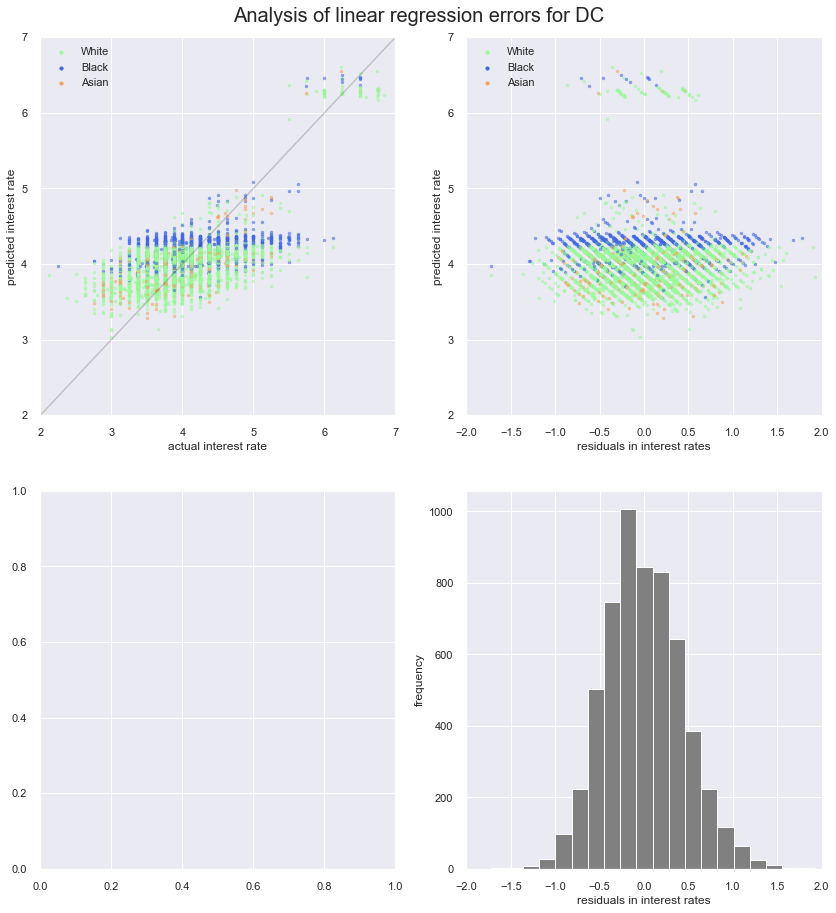

In [12]:
#############################
# define plotting functions #
#############################
interest_rates = list(MA.df_cat['interest_rate'])
race_Black = list(MA.df_cat['race_Black'])
race_Asian = list(MA.df_cat['race_Asian'])

def color_map(r_B, r_A):
    if r_B == 1:
        return 'royalblue'
    elif r_A == 1:
        return 'sandybrown'
    else:
        return 'palegreen'
    
def create_legend_pts(ax):
    ax.scatter(0, 0, alpha=1, s=10, c=color_map(0, 0), label='White')
    ax.scatter(0, 0, alpha=1, s=10, c=color_map(1, 0), label='Black')
    ax.scatter(0, 0, alpha=1, s=10, c=color_map(0, 1), label='Asian')
    ax.legend(loc='upper left')


fig, ax = plt.subplots(2,2, figsize = (14,14))
fig.suptitle("Analysis of linear regression errors for DC", size=20)
fig.subplots_adjust(top=0.95)
#############################
# plot actual vs. predicted #
#############################
ax[0,0].plot([2,7],[2,7], color='k', alpha=0.2)
c = 0
for ir, lmp, r_B, r_A in zip(interest_rates, list(lm_pred), race_Black, race_Asian):
    #print(ir, lmp, r_B, r_A)
    color = color_map(r_B, r_A)
    ax[0,0].scatter(ir, lmp, alpha=0.5, s=6, c=color)
    c +=1
    #if c> 100: break
ax[0,0].set_xlim([2,7])
ax[0,0].set_ylim([2,7])
ax[0,0].set_xlabel('actual interest rate')
ax[0,0].set_ylabel('predicted interest rate')
create_legend_pts(ax[0,0])

################################
# plot residuals vs. predicted #
################################
for rs, lmp, r_B, r_A in zip(residuals, list(lm_pred), race_Black, race_Asian):
    #print(ir, lmp, r_B, r_A)
    color = color_map(r_B, r_A)
    ax[0,1].scatter(rs, lmp, alpha= 0.5, s=6, c=color)
    #break
ax[0,1].set_xlim([-2,2])
ax[0,1].set_ylim([2,7])
ax[0,1].set_xlabel('residuals in interest rates')
ax[0,1].set_ylabel('predicted interest rate')
create_legend_pts(ax[0,1])

# plot histogram
ax[1,1].hist(residuals, bins=20, color='gray');
ax[1,1].set_xlim([-2,2])
ax[1,1].set_xlabel('residuals in interest rates')
ax[1,1].set_ylabel('frequency')






- notably, there are 2 interest rate clusters, the main one (3-5.5%) and the very high interest rate group (5.5-7%)
- the model performs best (small residuals) for high interest rates >4.5%, and lower interest rates <3.75%.  there is a large amount of unaccounted for variance in the most common interest rate band, from 3.75-4%
- there is a shift in black interest rates from white interest rates, observed in both actual and predicted interest rates

# 1.7 - Quantile Regression

We would like to further stratify the population, to understand who is most affected by interest rates discrimination.  Thus we perform quantile regression, regressing the 10th, 30th, 50th, 70th, and 90th percentiles within the population.

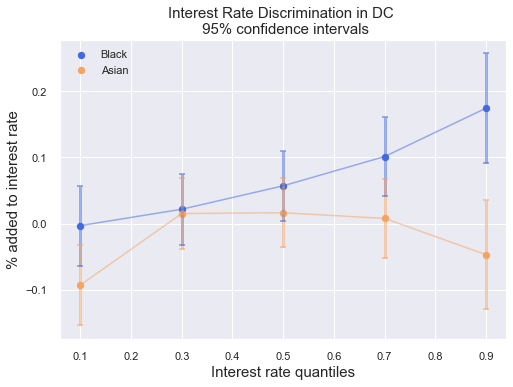

In [13]:
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'errorbar.capsize': 20})


quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]

black_quantiles = []
black_err = []
asian_quantiles = []
asian_err = []

for q in quantiles:
    return_dict = SA.quantile_regression(q, MA.df_cat, MA.analysis_keys, ['race_Black', 'race_Asian'], plot=False)
    black_quantiles.append(return_dict['race_Black'][0])
    black_err.append(return_dict['race_Black'][1])
    asian_quantiles.append(return_dict['race_Asian'][0])
    asian_err.append(return_dict['race_Asian'][1])

    
plt.figure()
plt.errorbar(quantiles, black_quantiles, yerr=black_err, color='royalblue', alpha=0.5, capsize=3, elinewidth=3, markeredgewidth=2)
plt.scatter(quantiles, black_quantiles, s = 40, color = "royalblue")
plt.errorbar(quantiles, asian_quantiles, yerr=asian_err, color='sandybrown', alpha=0.5, capsize=3, elinewidth=3, markeredgewidth=2)
plt.scatter(quantiles, asian_quantiles, s = 40, color = "sandybrown")
plt.xlabel('Interest rate quantiles', size= 15)
plt.ylabel('% added to interest rate', size= 15)
plt.title('Interest Rate Discrimination in DC \n 95% confidence intervals', size= 15)
plt.legend(['Black', 'Asian'])

- we observe that for Blacks, interest rate discrimination is more severe, the higher the interest rate, reaching about between 0.1 - 0.275% at the highest interest rate percentile.  The error bars for the Asian population may be too large to draw adequate conclusions - only that those charged the smallest interest rates also face the most reverse discrimination
- previous research (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1942424) has shown that interest rates are significantly influenced by shopping behavior, including how much effort one exerts in doing research and finding the best possible interest rates
- it is possible that those who fail to do adequate research, thus ending up with high interest rates, may possess other characteristics that subjectively result in them being deemed less credit worthy, thus leading to interest rate discrimination

# 1.8 - Effect of age on interest rate discrimination

We would also like to stratify our results based on the combination of race and age.  We take 3 age groups - "less than 30", "30-49 years old", and "oder than 50", with 3 races resulting in 9 age-race groups.  We take the group "White, 30-49 years old" to serve as the reference group, which is thus removed from the regression analysis

In [14]:
MA = MortgageAnalyzer()
MA.load_dataset("state_DC_2019.csv")
MA.filter_df()
MA.convert_categoricals()
analysis_keys = ['loan_amount','interest_rate', 'loan_to_value_ratio', 'property_value', 'income', 'loan_term', 'debt_to_income', 'preapproval_1', 'business_or_commercial_purpose_1',
        'purchaser_type_1', 'purchaser_type_2', 'purchaser_type_3', 'purchaser_type_5', 'purchaser_type_6', 'purchaser_type_8', 'purchaser_type_9', 'purchaser_type_71', 'purchaser_type_72',
        'open_end_line_of_credit_1', 'merge_race_age_Asian_30_to_49','merge_race_age_Asian_greater_than_50','merge_race_age_Asian_less_than_30','merge_race_age_Black_30_to_49','merge_race_age_Black_greater_than_50','merge_race_age_Black_less_than_30','merge_race_age_White_greater_than_50','merge_race_age_White_less_than_30'] 
    
MA.reduce_keys(analysis_keys)
df_ind_to_keep = SA.cooks_distance(MA.df_cat, MA.analysis_keys, plot=False)
MA.reduce_rows(df_ind_to_keep)
age_return_keys = ['merge_race_age_Asian_less_than_30','merge_race_age_Asian_30_to_49','merge_race_age_Asian_greater_than_50','merge_race_age_Black_less_than_30','merge_race_age_Black_30_to_49','merge_race_age_Black_greater_than_50','merge_race_age_White_less_than_30','merge_race_age_White_greater_than_50']
age_return_dict, _, _= SA.linear_regression(MA.df_cat, MA.analysis_keys, age_return_keys)

5752 datapoints remaining
5.5345705370339955% of data removed as outliers
Outliers have been removed 1 times.


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,2.8982,9.575312e-02,30.267315,8.337872e-187,0.372022,0.36917,2.710477e+00,3.085902e+00
1,loan_amount,-0.0000,8.453526e-08,-2.773097,5.570526e-03,0.372022,0.36917,-4.001456e-07,-6.870338e-08
2,loan_to_value_ratio,0.0041,7.668508e-04,5.307405,1.153835e-07,0.372022,0.36917,2.566670e-03,5.573305e-03
3,property_value,-0.0000,6.452764e-08,-1.517666,1.291539e-01,0.372022,0.36917,-2.244300e-07,2.856720e-08
4,income,0.0004,7.609136e-05,4.977489,6.630005e-07,0.372022,0.36917,2.295761e-04,5.279118e-04
5,loan_term,0.0016,2.157970e-04,7.514255,6.604661e-14,0.372022,0.36917,1.198510e-03,2.044597e-03
6,debt_to_income,0.0030,7.499181e-04,3.934485,8.436235e-05,0.372022,0.36917,1.480418e-03,4.420664e-03
7,preapproval_1,-0.0375,2.370178e-02,-1.581497,1.138197e-01,0.372022,0.36917,-8.394875e-02,8.980163e-03
8,business_or_commercial_purpose_1,0.6049,5.315467e-02,11.379155,1.104812e-29,0.372022,0.36917,5.006520e-01,7.090585e-01
9,purchaser_type_1,0.2977,2.131246e-02,13.967721,1.267400e-43,0.372022,0.36917,2.559061e-01,3.394671e-01


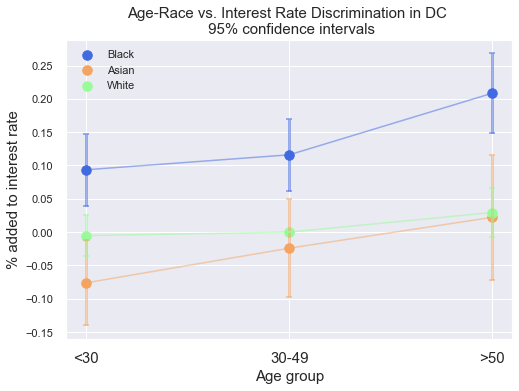

In [15]:
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'errorbar.capsize': 20})

extract_coef = lambda x: age_return_dict[x]['coef'].values[0]
extract_err = lambda x: (age_return_dict[x]['CI[97.5%]'].values[0] - age_return_dict[x]['CI[2.5%]'].values[0])/2

# extract coefs and errors
age_asian_coef = [extract_coef(age_return_keys[0]), extract_coef(age_return_keys[1]), extract_coef(age_return_keys[2])]
age_asian_err = [extract_err(age_return_keys[0]), extract_err(age_return_keys[1]), extract_err(age_return_keys[2])]
age_black_coef = [extract_coef(age_return_keys[3]), extract_coef(age_return_keys[4]), extract_coef(age_return_keys[5])]
age_black_err = [extract_err(age_return_keys[3]), extract_err(age_return_keys[4]), extract_err(age_return_keys[5])]
age_white_coef = [extract_coef(age_return_keys[6]), 0, extract_coef(age_return_keys[7])]
age_white_err = [extract_err(age_return_keys[6]), 0, extract_err(age_return_keys[7])]
    
plt.figure()
plt.errorbar(np.arange(3), age_black_coef, yerr=age_black_err, color='royalblue', alpha=0.5, capsize=3, elinewidth=3, markeredgewidth=2)
plt.errorbar(np.arange(3), age_asian_coef, yerr=age_asian_err, color='sandybrown', alpha=0.5, capsize=3, elinewidth=3, markeredgewidth=2)
plt.errorbar(np.arange(3), age_white_coef, yerr=age_white_err, color='palegreen', alpha=0.5, capsize=3, elinewidth=3, markeredgewidth=2)
plt.scatter(np.arange(3), age_black_coef, s = 90, color = "royalblue")
plt.scatter(np.arange(3), age_asian_coef, s = 90, color = "sandybrown")
plt.scatter(np.arange(3), age_white_coef, s = 90, color = "palegreen")
plt.xlabel('Age group', size= 15)
plt.xticks(np.arange(3), labels = ['<30','30-49','>50'], size= 15)
plt.ylabel('% added to interest rate', size= 15)
plt.title('Age-Race vs. Interest Rate Discrimination in DC \n 95% confidence intervals', size= 15)
plt.legend(['Black', 'Asian','White'])

- the above results demonstrate that age also has a large effect on interest rate discrimination, with a particularly large increase observed in going from Blacks from ages 30-49 (0.11%) to above 50 (+0.21%)
- Asians also experience a reverse discriminatory effect, but which is normalized with age, returning to near white levels of added interest rate after age 30
- shopping behavior is again a plausible explanation for why older individuals, who are less tech savy, may be able to find less optimal mortgage rates

# 2 - Analysis over DMV states - DC, Maryland, Virginia

We now repeat the above anaylsis over other states, Maryland and Virginia, which include much larger sample sizes.

In [16]:
analysis_keys = ['loan_amount','interest_rate', 'loan_to_value_ratio', 'property_value', 'income', 'loan_term', 'debt_to_income', 'merge_age', 'preapproval_1', 'business_or_commercial_purpose_1',
        'purchaser_type_1', 'purchaser_type_2', 'purchaser_type_3', 'purchaser_type_5', 'purchaser_type_6', 'purchaser_type_8', 'purchaser_type_9', 'purchaser_type_71', 'purchaser_type_72',
        'open_end_line_of_credit_1', 'race_Asian', 'race_Black'] 
    
return_keys = ['race_Black', 'race_Asian']

files = ["state_DC_2019.csv", "state_MD_2019.csv", "state_VA_2019.csv"]

N = []
def run_state(filepath, analysis_keys, return_keys):
    print(f'------ Running {filepath} ------')
    MA = MortgageAnalyzer()
    MA.load_dataset(filepath)
    MA.filter_df()
    MA.convert_categoricals()
    MA.reduce_keys(analysis_keys)
    SA = StatAnalysis()
    df_ind_to_keep = SA.cooks_distance(MA.df_cat, MA.analysis_keys, plot=False)
    MA.reduce_rows(df_ind_to_keep)
    return_dict = SA.linear_regression(MA.df_cat, MA.analysis_keys, return_keys, plot=False)
    
    # keep number of datapoints in analysis
    N.append(len(df_ind_to_keep))
    
    return return_dict
    
return_dict_list = []
for file in files:
    return_dict_list.append(run_state(file, analysis_keys, return_keys))

------ Running state_DC_2019.csv ------
5755 datapoints remaining
5.485301363113812% of data removed as outliers
Outliers have been removed 1 times.
------ Running state_MD_2019.csv ------
61664 datapoints remaining
4.804248487093985% of data removed as outliers
Outliers have been removed 1 times.
------ Running state_VA_2019.csv ------
96319 datapoints remaining
0.002076390402923558% of data removed as outliers
Outliers have been removed 1 times.


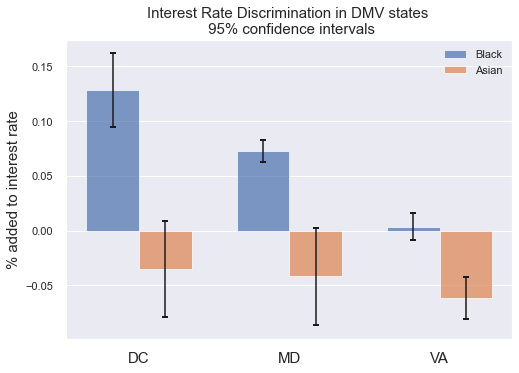

In [17]:
black_bias = []
black_error = []
asian_bias = []
asian_error = []
R2 = []

for return_dict in return_dict_list:
    black_bias.append(return_dict[0]['race_Black']['coef'].values[0])
    asian_bias.append(return_dict[0]['race_Asian']['coef'].values[0])
    black_error.append((return_dict[0]['race_Black']['CI[97.5%]'].values[0] - return_dict[0]['race_Black']['CI[2.5%]'].values[0])/2)
    asian_error.append((return_dict[0]['race_Asian']['CI[97.5%]'].values[0] - return_dict[0]['race_Black']['CI[2.5%]'].values[0])/2)
    
    R2.append(return_dict[0]['race_Black']['adj_r2'].values[0])

# make 
matplotlib.rcParams.update({'errorbar.capsize': 20})

width = 0.35  # the width of the bars
bar_inds = np.arange(len(return_dict_list))

#yerr=black_error
fig, ax = plt.subplots()
rects1 = ax.bar(bar_inds - width/2, black_bias, width, yerr=black_error, alpha=0.7, label='Black', error_kw={'markeredgewidth':2}, capsize=3)
rects2 = ax.bar(bar_inds + width/2, asian_bias, width, yerr=asian_error, alpha=0.7, label='Asian', error_kw={'markeredgewidth':2}, capsize=3)
ax.set_xticks(bar_inds)
ax.set_xticklabels(['DC', 'MD', 'VA'], size=15)
ax.set_ylabel('% added to interest rate', size= 15)
ax.set_title('Interest Rate Discrimination in DMV states \n 95% confidence intervals', size= 15)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.legend(loc= "upper right")


- the above analysis reveals a disparate picture over different states.  DC and MD both expereince statistically significant interest rate discrimination towards blacks, while VA does not
- reverse discrimination against Asians is both most statistically significant and strongest (on average) in Virginia
- it may be necessary to examine interest rate discrimination at the bank/lender level to understand why a disparate picture emerges in Virginia

# 2.1 - Summary Statistics over DMV states

Text(0.5, 1.0, 'Number of datapoints vs. State')

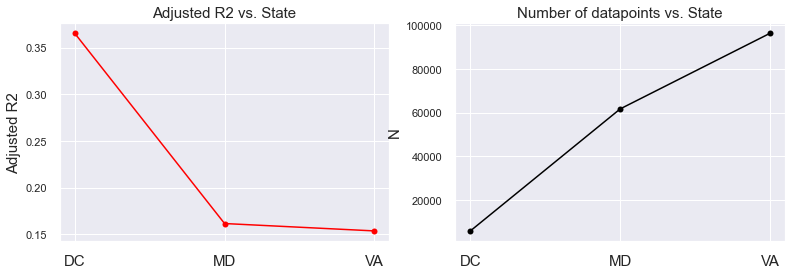

In [18]:
fig, ax = plt.subplots(1,2, figsize=(13,4))
ax = ax.ravel()

# plot adjusted R2
ax[0].plot(R2, '.-', color='red', markersize=12)
ax[0].set_xticks(bar_inds)
ax[0].set_xticklabels(['DC', 'MD', 'VA'], size=15)
ax[0].set_ylabel('Adjusted R2', size= 15)
ax[0].set_title('Adjusted R2 vs. State', size=15)

# plot N
ax[1].plot(N, '.-', color='black', markersize=12)
ax[1].set_xticks(bar_inds)
ax[1].set_xticklabels(['DC', 'MD', 'VA'], size=15)
ax[1].set_ylabel('N', size= 15)
ax[1].set_title('Number of datapoints vs. State', size=15)



- Note that both MD and VA have signficiantly lower R2, although this alone does not invalidate the interpretation of the coefficients (https://stats.stackexchange.com/questions/13314/is-r2-useful-or-dangerous/13317)  
- it would be useful to look at the residuals and examine whether the unexplained variance is localized to certain subpopulations

# 3 - Conclusions

Our results show evidence of moderate interest rate discrimination for African Americans in the states of DC and MD, and no statistically significant discrimination in the state of VA.   Additionally we observe reverse discrimination (lower interest rates than can be explained) against Asian Americans in all 3 states.  Age and quantile stratification suggest that interest rate discrimination is more severe for older and higher interest rate borrowers.

One of the shortcomings of this work is the lack of applicant credit rating information, which is essential in informing the interest rate he/she would have received.  Gender is another important factor which is known to impact lending rates, as women are known to acquire loans based on information from word-of-mouth, which can result in less competitive rates [2].

Future work could focus on more comprehensive analysis across multiple states, as well as per-institution trends, examining where in the process of interest rate assignment, either conducted by a loan officer or via fintech algorithms, racial biases might emerge.  Additionally, superior models for regressing interest rates can possibly be developed, as long as they don't falsely capture variance by overfitting.

# 4 - Supplementary

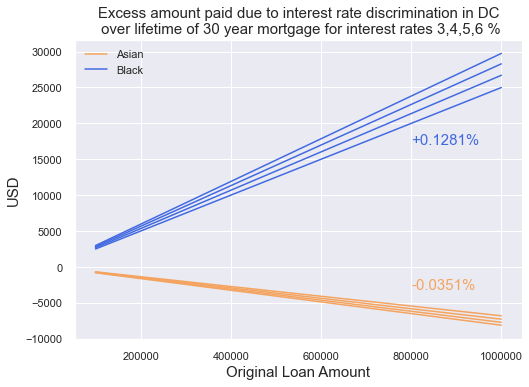

In [20]:
def compute_total(interest_rate, L):
    interest_rate_ = interest_rate / 12 /100
    # c - interest rate, L - loan amount
    P = lambda c,L:  L*(c*(1 + c)**n)/((1 + c)**n - 1) * n
    return P(interest_rate_,L)

plt.figure()
for interest_rate in [3,4,5,6]:
    for add_interest, c in zip([-0.0351, 0.1281],['sandybrown', 'royalblue']):
        L_ = np.arange(1e5,1e6)
        n = 360 
        E = compute_total(interest_rate+add_interest, L_) - compute_total(interest_rate, L_)
        plt.plot(L_,E, color=c)

plt.gca().ticklabel_format(style='plain')
plt.legend(['Asian', 'Black'])
plt.title('Excess amount paid due to interest rate discrimination in DC\n over lifetime of 30 year mortgage for interest rates 3,4,5,6 %', size=15)
plt.xlabel('Original Loan Amount', size=15)
plt.ylabel('USD', size=15)
plt.text(800000, 17000,'+0.1281%', size=15, color='royalblue');
plt.text(800000, -3200,'-0.0351%', size=15, color='sandybrown');

- using the average coefficients for Black and Asian borrowers in the DC metropolitan area, we see that interest rate discrimination can add up to tens of thousands USD in additional costs over the lifetime of a loan
- the strongest determinant of additional cost is just the original loan amount (which the excess amount is linear in)

# 5 - References

- [1] Racial Discrepancy in Mortage Interest Rates:  <br/> https://www.researchgate.net/publication/264555748_Racial_Discrepancy_in_Mortgage_Interest_Rates
- [2] Do Women Pay More for Mortgages? <br/> https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1942424